In [1]:
import epitomes
import cltk
import shap
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
epitome_texts, epitome_numbers = epitomes.load_epitomes('../epitomes')
with open('csvfiles/overlap_epitome_numbers.txt', 'r', encoding='utf-8') as f:
    nums = [int(num) for num in f.readlines()]

In [3]:
overlap_transcriptions = sorted(list(set(epitome_numbers).intersection(set(nums))))
overlap_transcriptions_idx = [i for i in range(len(epitome_numbers)) if epitome_numbers[i] in overlap_transcriptions]

In [4]:
difference_transcriptions = sorted(list(set(epitome_numbers).difference(set(nums))))
difference_transcriptions_idx = [i for i in range(len(epitome_numbers)) if epitome_numbers[i] in difference_transcriptions]

In [5]:
csvpath = 'csvfiles'
tfidf_dict = {}
feat_dict = {}
for filename in os.listdir(csvpath):
    if filename.startswith('tfidf'):
        n, r = re.findall('\d+', filename)
        n, r = int(n), int(r)
        if n not in tfidf_dict:
            tfidf_dict[n] = {}
        tfidf_dict[n][r] = np.genfromtxt(os.path.join(csvpath, filename), delimiter=',')
    elif filename.startswith('featnames'):
        n, r = re.findall('\d+', filename)
        n, r = int(n), int(r)
        with open(os.path.join(csvpath, filename), 'r', encoding='utf-8') as f:
            if n not in feat_dict:
                feat_dict[n] = {}
            feat_dict[n][r] = f.read().split('\n')
            feat_dict[n][r].pop(-1)

In [6]:
in_borrador = [1 if num in overlap_transcriptions else 0 for num in epitome_numbers]
n = 3
r = 300
n3_r300_df = pd.DataFrame(tfidf_dict[n][r], columns=feat_dict[n][r])
n3_r300_df['in_borrador'] = in_borrador

In [7]:
pos_mean_diff = (n3_r300_df[n3_r300_df.in_borrador == 0].iloc[:,:300].mean() - n3_r300_df[n3_r300_df.in_borrador == 1].iloc[:,:300].mean()).sort_values()
char_mean_diff = (n3_r300_df[n3_r300_df.in_borrador == 0].iloc[:,300:-1].mean() - n3_r300_df[n3_r300_df.in_borrador == 1].iloc[:,300:-1].mean()).sort_values()

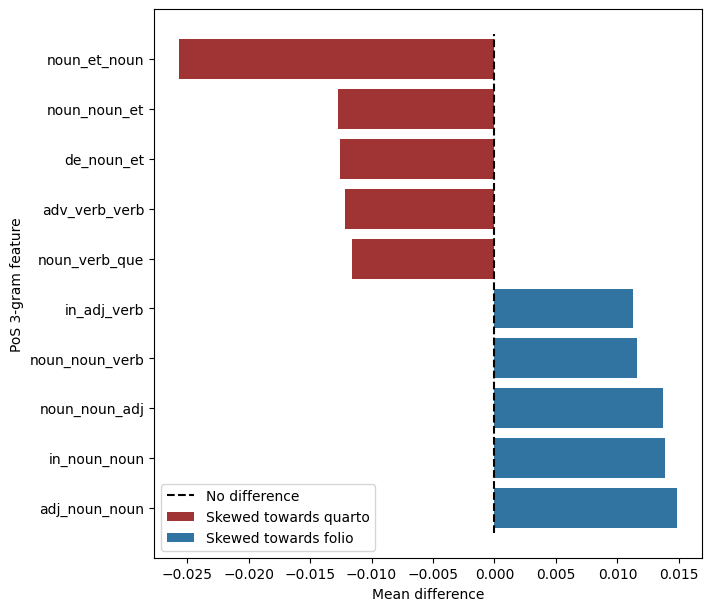

In [8]:
pos_head_names = [featname.replace(' ', '_') for featname in pos_mean_diff.head().index]
pos_tail_names = [featname.replace(' ', '_') for featname in pos_mean_diff.tail().index]
fig, ax = plt.subplots(layout='constrained')
fig.set_size_inches(7, 6)
sns.barplot(x=pos_mean_diff.head(), y=pos_head_names, ax=ax, color='firebrick', label='Skewed towards quarto')
sns.barplot(x=pos_mean_diff.tail(), y=pos_tail_names, ax=ax, label='Skewed towards folio')
ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], colors='black', linestyles='dashed', label='No difference')
ax.set_ylabel('PoS 3-gram feature')
ax.set_xlabel('Mean difference')
ax.legend();

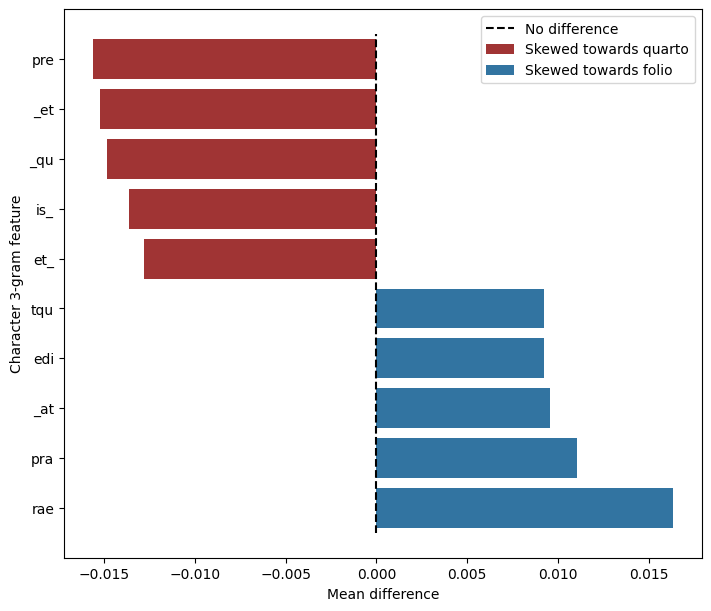

In [9]:
fig, ax = plt.subplots(layout='constrained')
fig.set_size_inches(7, 6)
char_head_names = [featname.replace(' ', '_') for featname in char_mean_diff.head().index]
char_tail_names = [featname.replace(' ', '_') for featname in char_mean_diff.tail().index]
sns.barplot(x=char_mean_diff.head(), y=char_head_names, ax=ax, color='firebrick', label='Skewed towards quarto')
sns.barplot(x=char_mean_diff.tail(), y=char_tail_names, ax=ax, label='Skewed towards folio')
ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], colors='black', linestyles='dashed', label='No difference')
ax.set_ylabel('Character 3-gram feature')
ax.set_xlabel('Mean difference')
ax.legend();

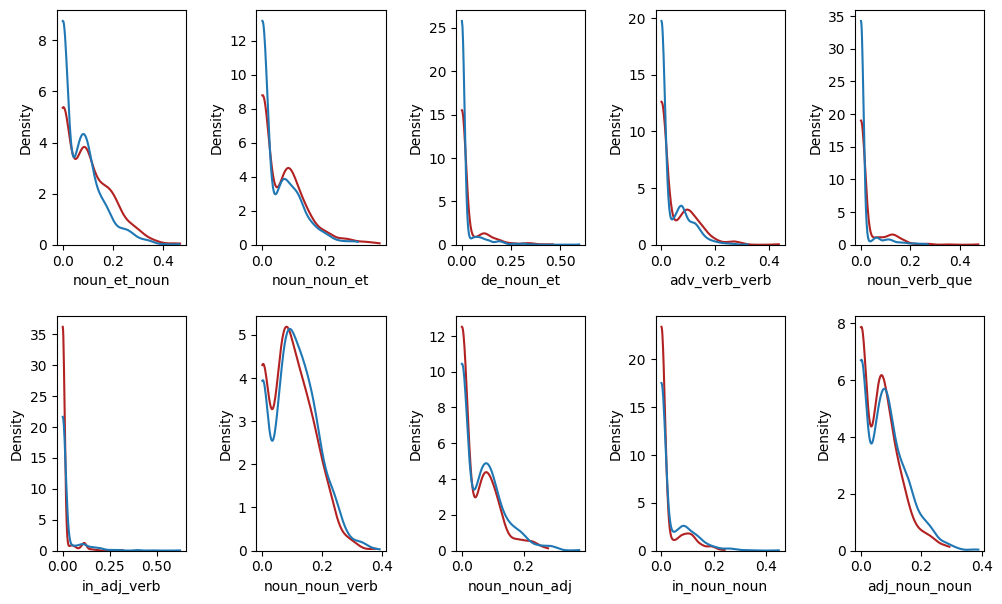

In [10]:
# It seems that the mean differences mainly come from zero values.
# That is, pos-grams skewed towards quarto have less density around 0.
# And then pos-grams skewed towards folio also have less density around 0.
# It seems that the quarto has a preference for  the conjunctions et and qu(e). 
# This is also visible in the 1st row in the char gram plot.
fig, axes = plt.subplots(2, 5)
fig.set_size_inches(10, 6)
fig.tight_layout(h_pad=3, w_pad=2)
pos_diffs = pd.concat([pos_mean_diff.head(), pos_mean_diff.tail()])
for idx, ax in enumerate(axes.reshape(-1)):
    feat = pos_diffs.index[idx]
    #sns.histplot(data=n3_r300_df, x=feat, hue='in_borrador', ax=ax, common_norm=False)
    sns.kdeplot(n3_r300_df[feat][n3_r300_df.in_borrador == 1], label='Quarto', color='firebrick', ax=ax, cut=0,)
    sns.kdeplot(n3_r300_df[feat][n3_r300_df.in_borrador == 0], label='Folio', ax=ax, cut=0,)
    ax.set_xlabel(feat.replace(' ', '_'))

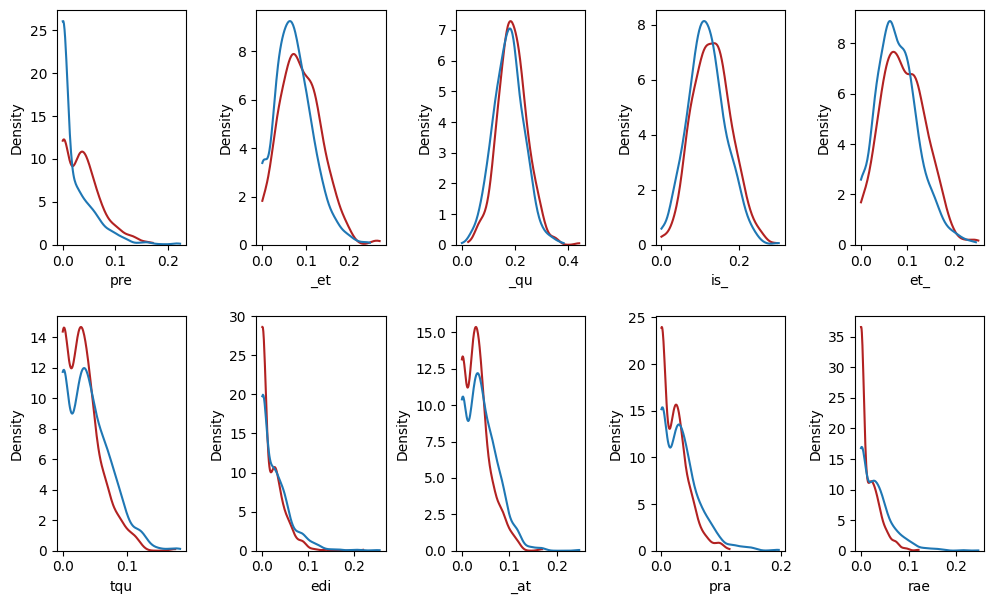

In [11]:
# The picture is similar for the character ngrams. Here, the ngrams dists
# all have roughly the same shape. But ngrams skewed towards the quarto (1st row)
# are shifted slightly right, meaning more positive values. Ngrams skewed 
# towards the folio (2nd row) are also shifted slightly right and have less
# density around the 0 mark. It seems that the quarto has a preference for 
# the conjunctions et and qu(e). This is also visible in the 1st row in 
# the pos gram plot.
fig, axes = plt.subplots(2, 5)
fig.set_size_inches(10, 6)
fig.tight_layout(h_pad=3, w_pad=2)
char_diffs = pd.concat([char_mean_diff.head(), char_mean_diff.tail()])
for idx, ax in enumerate(axes.reshape(-1)):
    feat = char_diffs.index[idx]
    #sns.histplot(data=n3_r300_df, x=feat, hue='in_borrador', ax=ax, common_norm=False)
    sns.kdeplot(n3_r300_df[feat][n3_r300_df.in_borrador == 1], label='Quarto', color='firebrick', ax=ax, cut=0,)
    sns.kdeplot(n3_r300_df[feat][n3_r300_df.in_borrador == 0], label='Folio', ax=ax, cut=0,)
    ax.set_xlabel(feat.replace(' ', '_'))


In [12]:
# epitomes at idx 673 and 417 are both examples from the quarto
# where the author lists things in pairs - these illustrate why
# noun_et_noun is skewed towards the quarto
n3_r300_df.sort_values(by='noun et noun').tail(3)

,ab adj noun,ab noun noun,ab noun verb,ad adj noun,ad noun adj,ad noun noun,ad noun verb,adj adj noun,adj adj verb,adj adp adj,...,uis,ulu,um,und,uo,ura,us,ut,uus,in_borrador
417,0.0,0.0,0.0,0.0,0.0,0.071546,0.0,0.00000,0.152604,0.0,...,0.074188,0.000000,0.197844,0.000000,0.078608,0.082996,0.306025,0.014342,0.085233,1
828,0.0,0.0,0.0,0.0,0.0,0.084092,0.0,0.00000,0.000000,0.0,...,0.066860,0.000000,0.214621,0.027623,0.000000,0.093497,0.328328,0.000000,0.021337,0
673,0.0,0.0,0.0,0.0,0.0,0.077052,0.0,0.06575,0.000000,0.0,...,0.014991,0.015069,0.144364,0.074321,0.000000,0.146745,0.452739,0.028980,0.057410,1


In [13]:
# cont. from above: they have the following epitome numbers
epitome_numbers[417], epitome_numbers[673]

(710, 1116)

In [14]:
lat_cltk = cltk.NLP(language='lat', suppress_banner=True)
lat_cltk.pipeline.processes.remove(cltk.lexicon.processes.LatinLexiconProcess)
lat_cltk.pipeline.processes.remove(cltk.embeddings.processes.LatinEmbeddingsProcess)

In [27]:
cltk_710 = lat_cltk.analyze(epitome_texts[417])
cltk_1116 = lat_cltk.analyze(epitome_texts[673])

Unrecognized value 'Perf' for UD feature 'Tense'.
If you believe this is not an error in the dependency parser, please raise an issue at <https://github.com/cltk/cltk/issues> and include a short text to reproduce the error.

Unrecognized value 'Perf' for UD feature 'Tense'.
If you believe this is not an error in the dependency parser, please raise an issue at <https://github.com/cltk/cltk/issues> and include a short text to reproduce the error.

Unrecognized value 'Perf' for UD feature 'Tense'.
If you believe this is not an error in the dependency parser, please raise an issue at <https://github.com/cltk/cltk/issues> and include a short text to reproduce the error.

Unrecognized value 'Perf' for UD feature 'Tense'.
If you believe this is not an error in the dependency parser, please raise an issue at <https://github.com/cltk/cltk/issues> and include a short text to reproduce the error.

Unrecognized value 'Perf' for UD feature 'Tense'.
If you believe this is not an error in the depende

In [28]:
nounetnoun710 = [i for i in range(len(cltk_710.tokens)) if cltk_710.tokens[i] == 'et' and cltk_710.pos[i-1] == 'NOUN' and cltk_710.pos[i+1] == 'NOUN']
nounetnoun1116 = [i for i in range(len(cltk_1116.tokens)) if cltk_1116.tokens[i] == 'et' and cltk_1116.pos[i-1] == 'NOUN' and cltk_1116.pos[i+1] == 'NOUN']

In [29]:
nounetnoun1116

[15, 94, 101, 144, 148, 153, 168, 173, 178, 180, 182]

In [33]:
' '.join(cltk_1116.tokens[140:190])

'corporum que coelestium natura et motu deque generatione et corruptione ac elementorum ordine et natura de metheorologias impressionibus et de natura anime et suarum potentiarum Item de sensu et sensatis seu sensuum obiectis et operationibus necnon de memoria et reminiscentia et causis et vigilie vite que brevis et longe nihil'

In [34]:
n3_r300_df.sort_values(by='rae').tail()[['rae', 'in_borrador']]

,rae,in_borrador
1258,0.170884,0
800,0.176666,0
1336,0.210789,0
1141,0.218763,0
1081,0.246905,0


In [35]:
epitome_numbers[1081], epitome_numbers[1141]

(1901, 1961)

## Pretending this is a binary classification problem

In [36]:
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [50]:
proper_clf = LogisticRegressionCV(cv=5, scoring='f1', max_iter=5000, solver='liblinear')
freq_clf = DummyClassifier(strategy='most_frequent')
uniform_clf = DummyClassifier(strategy='uniform')
X = n3_r300_df.iloc[:, :-1]
y = n3_r300_df.in_borrador
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33)

In [56]:
proper_clf.fit(X_train, y_train)
freq_clf.fit(X_train, y_train)
uniform_clf.fit(X_train, y_train)
proper_y_pred = proper_clf.predict(X_test)
freq_ypred = freq_clf.predict(X_test)
uniform_ypred = uniform_clf.predict(X_test)
proper_acc = accuracy_score(y_test, proper_y_pred)
proper_f1 = f1_score(y_test, proper_y_pred)
freq_acc = accuracy_score(y_test, freq_ypred)
freq_f1 = f1_score(y_test, freq_ypred)
uniform_acc = accuracy_score(y_test, uniform_ypred)
uniform_f1 = f1_score(y_test, uniform_ypred)
print(f'Proper clf:')
print(f'Accuracy: {proper_acc:.2f}')
print(f'F1-score: {proper_f1:.2f}')
print()
print('Most frequent:')
print(f'Accuracy: {freq_acc:.2f}')
print(f'F1-score: {freq_f1:.2f}')
print()
print('Uniform:')
print(f'Accuracy: {uniform_acc:.2f}')
print(f'F1-score: {uniform_f1:.2f}')

Proper clf:
Accuracy: 0.74
F1-score: 0.58

Most frequent:
Accuracy: 0.67
F1-score: 0.00

Uniform:
Accuracy: 0.50
F1-score: 0.40


In [61]:
weights = proper_clf.coef_.flatten()
feats = X.columns
pos_weights_df = pd.DataFrame({'weight': weights[:300], 'feature': feats[:300], 'odds_ratio': np.exp(weights[:300])})
char_weights_df = pd.DataFrame({'weight': weights[300:], 'feature': feats[300:], 'odds_ratio': np.exp(weights[300:])})

In [62]:
#5 most positive weights
pos_weights_df.sort_values(by='weight').tail()

,weight,feature,odds_ratio
133,5.432219,noun adp adj,228.656020
254,5.528776,verb cconj verb,251.835394
17,5.602527,adj et noun,271.110583
207,6.009693,noun verb possum,407.358091
181,6.604957,noun qui adj,738.748240


In [63]:
#5 most negative weights
pos_weights_df.sort_values(by='weight').head()

,weight,feature,odds_ratio
111,-5.637672,in noun noun,0.003561
113,-5.398563,in qui noun,0.004523
197,-5.033455,noun verb atque,0.006516
229,-4.917195,qui adv noun,0.007320
33,-4.801493,adj verb adj,0.008217


In [64]:
#5 most positive weights
char_weights_df.sort_values(by='weight').tail()

,weight,feature,odds_ratio
248,5.746094,s o,312.965722
77,5.917165,dam,371.357470
193,5.981477,o e,396.024708
33,6.414914,qu,610.888511
213,9.818009,pre,18361.462108


In [65]:
#5 most negative weights
char_weights_df.sort_values(by='weight').head()

,weight,feature,odds_ratio
225,-7.640217,rae,0.000481
268,-7.552690,t q,0.000525
93,-6.435731,edi,0.001603
81,-6.061350,dis,0.002331
32,-5.446288,pr,0.004312


In [66]:
# Permutation Importance
perm_importance = permutation_importance(proper_clf, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance Mean': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
})
print("\nPermutation Importance:")
print(perm_importance_df.sort_values(by='Importance Mean', ascending=False))


Permutation Importance:
            Feature  Importance Mean  Importance Std
513             pre         0.034314        0.010520
177  noun noun verb         0.027732        0.012779
79     de noun noun         0.022556        0.009480
68    adv verb verb         0.022440        0.004735
174   noun noun qui         0.020176        0.008014
..              ...              ...             ...
319              is        -0.006189        0.004729
592             ulu        -0.006817        0.003438
376             cus        -0.007351        0.006662
102   hic noun verb        -0.007522        0.006323
112    in noun verb        -0.013516        0.004908

[600 rows x 3 columns]


In [67]:
perm_importance_df[perm_importance_df.Feature.isin(X.columns[:300])].sort_values(by='Importance Mean', ascending=False)

,Feature,Importance Mean,Importance Std
177,noun noun verb,0.027732,0.012779
79,de noun noun,0.022556,0.009480
68,adv verb verb,0.022440,0.004735
174,noun noun qui,0.020176,0.008014
152,noun et noun,0.018631,0.008249
...,...,...,...
276,verb noun noun,-0.005289,0.003220
199,noun verb de,-0.005356,0.003872
17,adj et noun,-0.005731,0.006119
102,hic noun verb,-0.007522,0.006323


In [68]:
perm_importance_df[perm_importance_df.Feature.isin(X.columns[300:])].sort_values(by='Importance Mean', ascending=False)

,Feature,Importance Mean,Importance Std
513,pre,0.034314,0.010520
333,qu,0.019930,0.011998
393,edi,0.019300,0.009607
493,o e,0.019039,0.008063
509,par,0.018827,0.007509
...,...,...,...
586,uam,-0.005009,0.002397
411,es,-0.005893,0.002729
319,is,-0.006189,0.004729
592,ulu,-0.006817,0.003438


In [252]:
n3_r300_df.sort_values(by='noun et noun')['noun et noun']

707    0.000000
805    0.000000
806    0.000000
807    0.000000
808    0.000000
         ...   
418    0.379559
975    0.404462
417    0.436055
828    0.465924
673    0.469609
Name: noun et noun, Length: 1416, dtype: float64

In [256]:
n3_r300_df.max().sort_values()

t i                  0.109392
a e                  0.127684
n q                  0.127789
beo                  0.133052
ndo                  0.140157
                       ...   
noun noun noun       0.750083
de noun de           0.762542
noun ab noun         0.799712
propn propn propn    0.961326
in_borrador          1.000000
Length: 601, dtype: float64